## Moorers Reverb
Similar to Schroeders Reverb, except Comb filters used are replaced with LPF comb filters and only one APF is used

In [1]:
# Setup
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import sys
import requests
import io
from CircularBuffer import CircularBuffer, StereoDelay
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq, rfft, rfftfreq, ifft, irfft

# URL of the raw wave file on GitHub
# un-comment the URL of the file you want to use
# ATF Drums
#github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/Around%20the%20fur%20drums.wav"
# KYW inst
github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/KYW%20Inst.wav"

# Fetch the wave file from GitHub
response = requests.get(github_url)

# Check if the request was successful
if response.status_code == 200:
    # Read the wave data from the response content
    wave_data = io.BytesIO(response.content)
    
    # Read the wave file 
    fs, data = wavfile.read(wave_data)
    
else:
    print("Failed to fetch the wave file from GitHub")


# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")


Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


In [2]:
# Setting up IIR Lowpass filter
# Can probably be replaced with multiple with different cutoffs for better effect, but just 
# Using one for now to test
fc = 9000
b, a = signal.iirfilter(3, fc, btype='lowpass', ftype='butter', output='ba', fs=fs)

In [3]:
#Comb filters
N = 6
parallel_delayLines = [None] * N
gains = [0.46, 0.47, 0.475, 0.48, 0.49, 0.5]
delays = [0.050, 0.056, 0.061, 0.068, 0.072, 0.078]
output_comb = np.zeros((len(data), 2))

# APF 1
delayTime1 = 0.006
delaySamples1 = delayTime1 * fs
g1 = 0.7
delayLine1 = StereoDelay(delaySamples1, delaySamples1)
output_apf1 = np.zeros((len(data), 2))

# initialise delay lines
for i in range(N):
    parallel_delayLines[i] = StereoDelay((delays[i] * fs), (delays[i] * fs))



for j in range(N):
    for i in range(len(data)):
        #Comb Filter
        delayed = 0

        delayed = parallel_delayLines[j].get_samples_from_buffer()

        output_comb[i] += delayed

        delayed = signal.lfilter(b, a, delayed)

        delayed = np.multiply(delayed, gains[j])

        parallel_delayLines[j].push_samples_to_buffer(delayed + data[i])


for i in range(len(data)):
    #APF1
    delayed1 = delayLine1.get_samples_from_buffer()

    delayLine1.push_samples_to_buffer(output_comb[i] + np.multiply(delayed1, g1))

    output_apf1[i] = (-g1 * output_comb[i]) + np.multiply((1 - pow(g1,2)), delayed1)




In [4]:
#Wet/Dry
wetAmt = 0.7

output_apf1 = np.multiply((1-wetAmt), data) + np.multiply((wetAmt), output_apf1)

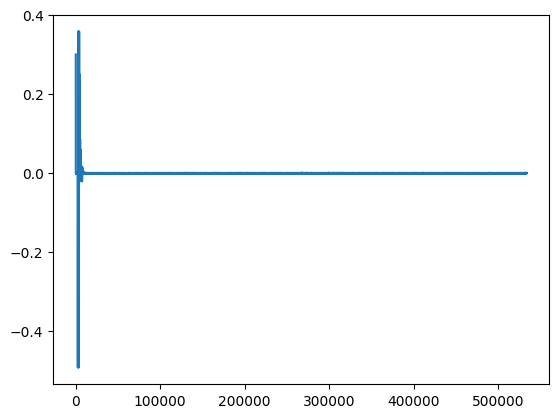

In [5]:
# Apply windowing
window = hann(len(data))
original_signal = data[:,0] * window
filtered_signal = output_apf1[:,0] * window

original_spectrum = fft(original_signal)
filtered_spectrum = fft(filtered_signal)

epsilon = 1e-10

impulse_response_spectrum = filtered_spectrum/(original_spectrum + epsilon)

impulse_response = np.real(ifft(impulse_response_spectrum))

plt.plot(impulse_response)

In [6]:
#Normalisation
max_amplitude = np.max(np.abs(output_apf1))
normalized_audio = output_apf1 / max_amplitude

In [7]:
sd.play(normalized_audio, fs)

In [8]:
#sf.write("MoorersKYW.wav", normalized_audio, fs)